In [7]:
import torch , numpy as np, matplotlib.pyplot as plt

Text(0.5, 1.0, 'Objectives Scatter Plot')

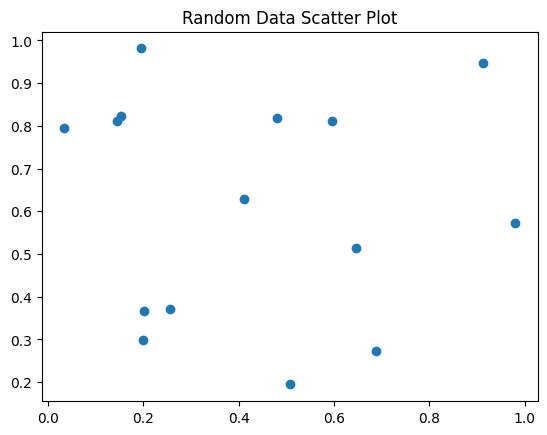

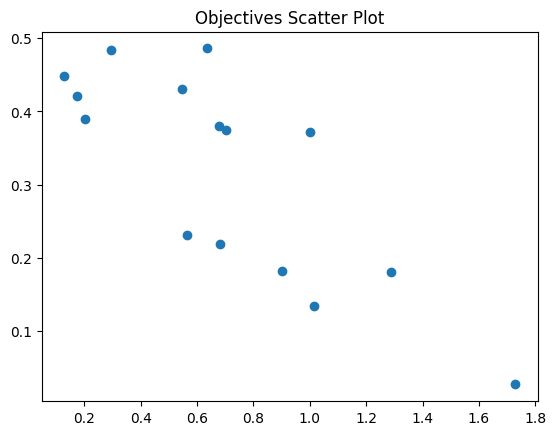

In [167]:
# generate random data
data = torch.rand((15, 2), dtype=torch.float32)
plt.scatter(data[:, 0].numpy(), data[:, 1].numpy())
plt.title("Random Data Scatter Plot")

objectives = torch.zeros((data.shape[0], 2), dtype=torch.float32)
for i in range(data.shape[0]):
    x, y = data[i]
    objectives[i, 0] = x**2 + y**2  # Objective 1: Minimize distance from origin
    objectives[i, 1] = 2**(x - 1) + (y - 1)**2- x**y  # Objective 2: Minimize distance from (1,1)
    
plt.figure()
plt.scatter(objectives[:, 0].numpy(), objectives[:, 1].numpy())
plt.title("Objectives Scatter Plot")

In [168]:
# we implement Fast nondominated sorting here

# first patero dominance check
def is_dominated(a, b):
    return all(a >= b) and any(a > b)

# fast nondominated sorting
def fast_nondominated_sort(population):
    S = [[] for _ in range(len(population))] # Dominated sets
    n = [0 for _ in range(len(population))] # Domination counts
    rank = [0 for _ in range(len(population))]
    fronts = [[]]

    for p in range(len(population)):
        for q in range(len(population)):
            if is_dominated(population[p], population[q]):
                S[q].append(p)
                n[p] += 1
            elif is_dominated(population[q], population[p]):
                n[q] += 1
                S[p].append(q)
        if n[p] == 0:
            rank[p] = 0
            fronts[0].append(p)

    i = 0
    while fronts[i]:
        next_front = []
        for p in fronts[i]:
            for q in S[p]:
                n[q] -= 1
                if n[q] == 0:
                    rank[q] = i + 1
                    next_front.append(q)
        i += 1
        fronts.append(next_front)

    fronts.pop()
    return fronts

Nondominated fronts: [[4, 6, 7, 8, 9, 11, 12, 14], [3, 0, 2, 10, 5, 13], [1]]
Front 1 points: tensor([[0.2562, 0.3700],
        [0.4110, 0.6283],
        [0.9123, 0.9467],
        [0.2005, 0.3658],
        [0.4801, 0.8190],
        [0.6469, 0.5145],
        [0.5951, 0.8119],
        [0.1996, 0.2991]])
Front 2 points: tensor([[0.1447, 0.8113],
        [0.6873, 0.2735],
        [0.1947, 0.9812],
        [0.1528, 0.8237],
        [0.9800, 0.5718],
        [0.5081, 0.1943]])
Front 3 points: tensor([[0.0338, 0.7957]])


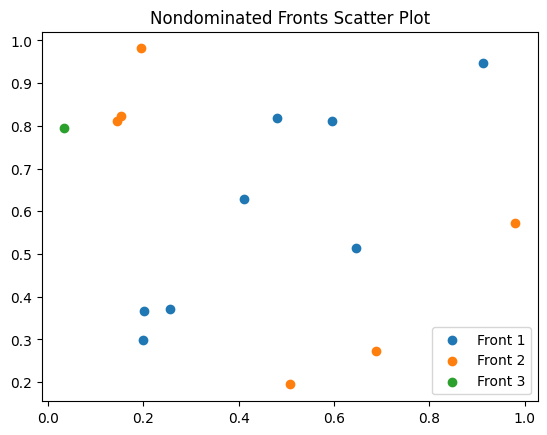

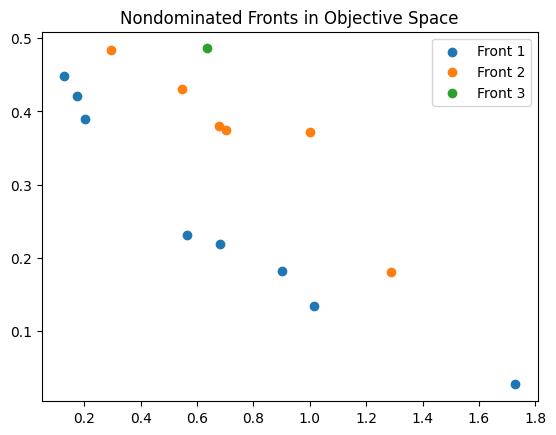

In [169]:
fronts = fast_nondominated_sort(objectives)
print("Nondominated fronts:", fronts)


for i, front in enumerate(fronts):
    front_points = data[front]
    print(f"Front {i+1} points: {front_points}")
    plt.scatter(front_points[:, 0].numpy(), front_points[:, 1].numpy(),
                label=f'Front {i+1}')

plt.legend()
plt.title("Nondominated Fronts Scatter Plot")
plt.show()

plt.figure()
for i, front in enumerate(fronts):
    front_objectives = objectives[front]
    plt.scatter(front_objectives[:, 0].numpy(), front_objectives[:, 1].numpy(),
                label=f'Front {i+1}')
plt.legend()
plt.title("Nondominated Fronts in Objective Space")
plt.show()

In [195]:
# now we difine the Crowding distance
def normalized_distance(values,index):
    max_value = torch.max(values)
    min_value = torch.min(values)
    if max_value - min_value == 0:
        return 0.0
    return (values[index-1] - values[index+1]) / (max_value - min_value) if index > 0 and index < len(values) - 1 else float('inf')
def crowding_distance(population, front):
    distance = torch.zeros(len(front))
    for m in range(population.shape[1]): # for each objective
        # print(f"Calculating crowding distance for dimension {m}, curent distance: {distance}")
        obj_values = population[front, m]
        sorted_indices = torch.argsort(obj_values)
        distance[sorted_indices[0]] = float('inf')
        distance[sorted_indices[-1]] = float('inf')
        print(f"distance after setting boundaries for objective {m}: {distance}")
        for i in range(1, len(front) - 1):
            print(f"Calculating distance for index {i} in front {front}, obj_values: {obj_values}, sorted_indices: {sorted_indices}, index: {i}, normalized_distance: {normalized_distance(obj_values, sorted_indices[i])}")
            distance[sorted_indices[i]] += normalized_distance(torch.sort(obj_values)[0], i)
            # print(f"Distance at index {sorted_indices[i]}: {distance[sorted_indices[i]]}")
        print(f"Final distance for objective {m}: {distance}")
    return distance

In [196]:
# now we define the selection operator based on tournament selection
def tournament_selection(population, fronts, k=2):
    selected = []
    for _front in fronts:
        # print(f"Selected so far: {selected}")
        if len(selected)+ len(_front) > k:
            # choose exactly len(_font)-(len(selected)-k) individuals based on crowding distance
            distances = crowding_distance(population, _front)
            sorted_indices = torch.argsort(distances, descending=True)
            selected.extend([_front[i] for i in sorted_indices[:k - (len(selected))]])
            break
        selected.extend(_front)
    return selected

In [197]:
objectives[fronts[0]], objectives[4]

(tensor([[0.2026, 0.3898],
         [0.5637, 0.2310],
         [1.7285, 0.0271],
         [0.1740, 0.4212],
         [0.9013, 0.1819],
         [0.6832, 0.2194],
         [1.0134, 0.1345],
         [0.1293, 0.4479]]),
 tensor([0.2026, 0.3898]))

distance after setting boundaries for objective 0: tensor([0., 0., inf, 0., 0., 0., 0., inf])
Calculating distance for index 1 in front [4, 6, 7, 8, 9, 11, 12, 14], obj_values: tensor([0.2026, 0.5637, 1.7285, 0.1740, 0.9013, 0.6832, 1.0134, 0.1293]), sorted_indices: tensor([7, 3, 0, 1, 5, 4, 6, 2]), index: 1, normalized_distance: 0.5172460675239563
Calculating distance for index 2 in front [4, 6, 7, 8, 9, 11, 12, 14], obj_values: tensor([0.2026, 0.5637, 1.7285, 0.1740, 0.9013, 0.6832, 1.0134, 0.1293]), sorted_indices: tensor([7, 3, 0, 1, 5, 4, 6, 2]), index: 2, normalized_distance: inf
Calculating distance for index 3 in front [4, 6, 7, 8, 9, 11, 12, 14], obj_values: tensor([0.2026, 0.5637, 1.7285, 0.1740, 0.9013, 0.6832, 1.0134, 0.1293]), sorted_indices: tensor([7, 3, 0, 1, 5, 4, 6, 2]), index: 3, normalized_distance: -0.9541621804237366
Calculating distance for index 4 in front [4, 6, 7, 8, 9, 11, 12, 14], obj_values: tensor([0.2026, 0.5637, 1.7285, 0.1740, 0.9013, 0.6832, 1.0134, 0.

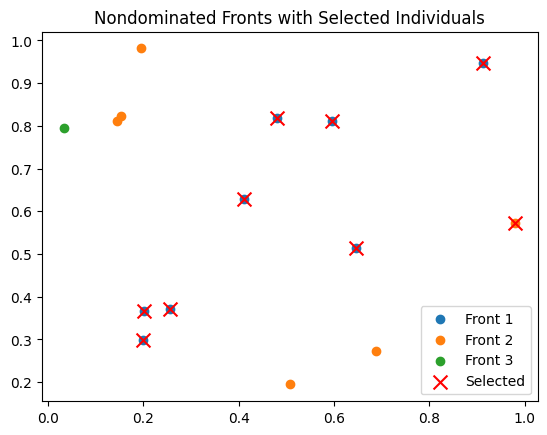

Front 1 objective points: tensor([[0.2026, 0.3898],
        [0.5637, 0.2310],
        [1.7285, 0.0271],
        [0.1740, 0.4212],
        [0.9013, 0.1819],
        [0.6832, 0.2194],
        [1.0134, 0.1345],
        [0.1293, 0.4479]])
Front 2 objective points: tensor([[0.6791, 0.3799],
        [0.5471, 0.4304],
        [1.0006, 0.3718],
        [0.7018, 0.3742],
        [1.2874, 0.1811],
        [0.2959, 0.4835]])
Front 3 objective points: tensor([[0.6342, 0.4860]])


Text(0.5, 1.0, 'Objectives with Selected Individuals')

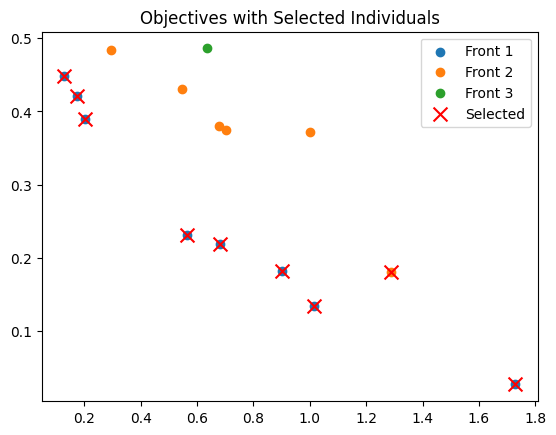

In [201]:
# example usage of crowding distance and tournament selection
for front in fronts:
    # print(f"Front: {data[front]}")
    distances = crowding_distance(objectives, front)
    print(f"Crowding distances for front {front}: {distances}")
selected_indices = tournament_selection(objectives, fronts, k=9)
print(f"Selected individuals: {selected_indices}")


for i, front in enumerate(fronts):
    front_points = data[front]
    print(f"Front {i+1} points: {front_points}")
    plt.scatter(front_points[:, 0].numpy(), front_points[:, 1].numpy(),
                label=f'Front {i+1}')
plt.scatter(data[selected_indices, 0].numpy(), data[selected_indices, 1].numpy(),
            color='red', marker='x', s=100, label='Selected')
plt.legend()
plt.title("Nondominated Fronts with Selected Individuals")
plt.show()

# another figure of objectives with selected individuals
plt.figure()
for i, front in enumerate(fronts):
    front_points = objectives[front]
    print(f"Front {i+1} objective points: {front_points}")                       
    plt.scatter(front_points[:, 0].numpy(), front_points[:, 1].numpy(),
                label=f'Front {i+1}')
plt.scatter(objectives[selected_indices, 0].numpy(), objectives[selected_indices, 1].numpy(),
            color='red', marker='x', s=100, label='Selected')
plt.legend()
plt.title("Objectives with Selected Individuals")

Parent 1: tensor([0.6873, 0.2735]), Parent 2: tensor([0.0338, 0.7957])
Child 1: tensor([0.6873, 0.2735]), Child 2: tensor([0.0338, 0.7957])
Mutation random value: 0.27401894330978394 for gene index 0
Mutation random value: 0.6137098073959351 for gene index 1
Mutated Child 1: tensor([0.6873, 0.2735])


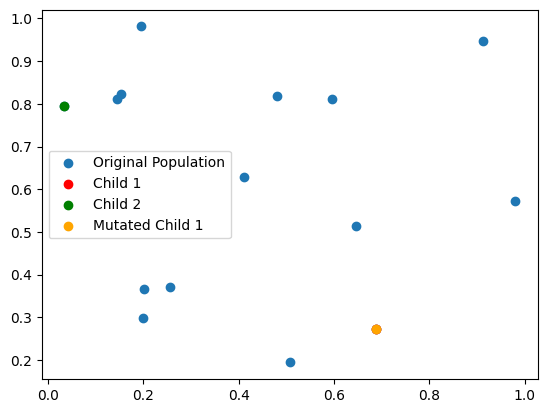

In [239]:
# now we define here the crossover and mutation operators
def crossover(parent1, parent2, crossover_rate=0.4):
    if torch.rand(1).item() > crossover_rate:
        return parent1.clone(), parent2.clone()
    alpha = torch.rand(1).item()
    child1 = alpha * parent1 + (1 - alpha) * parent2
    child2 = (1 - alpha) * parent1 + alpha * parent2
    return child1, child2


# TODO repair the mutation , the current one do not change anything
def mutate(individual, mutation_rate=0.2, mutation_strength=0.08):
    individual = individual.clone()
    for i in range(len(individual)):
        rd= torch.rand(1).item()
        print(f"Mutation random value: {rd} for gene index {i}")
        if rd < mutation_rate:
            individual[i] += torch.randn(1).item() * mutation_strength
            individual[i] = torch.clamp(individual[i], 0.0, 1.0) # assuming bounds [0,1]
    return individual

# example usage of crossover and mutation
parent1 = data[0]
parent2 = data[1]
child1, child2 = crossover(parent1, parent2)
print(f"Parent 1: {parent1}, Parent 2: {parent2}")
print(f"Child 1: {child1}, Child 2: {child2}")
mutated_child1 = mutate(child1)
print(f"Mutated Child 1: {mutated_child1}")

plt.figure()
plt.scatter(data[:, 0].numpy(), data[:, 1].numpy(), label='Original Population')
plt.scatter(child1[0].item(), child1[1].item(), color='red', label='Child 1')
plt.scatter(child2[0].item(), child2[1].item(), color='green', label='Child 2')
plt.scatter(mutated_child1[0].item(), mutated_child1[1].item(), color='orange', label='Mutated Child 1')
plt.legend()

Generation 1
Mutation random value: 0.9558649659156799 for gene index 0
Mutation random value: 0.7332206964492798 for gene index 1
Mutation random value: 0.871666669845581 for gene index 0
Mutation random value: 0.5875732898712158 for gene index 1
Mutation random value: 0.7575557827949524 for gene index 0
Mutation random value: 0.7470743060112 for gene index 1
Mutation random value: 0.8294196724891663 for gene index 0
Mutation random value: 0.2291719913482666 for gene index 1
Mutation random value: 0.7014392614364624 for gene index 0
Mutation random value: 0.18702232837677002 for gene index 1
Mutation random value: 0.26770228147506714 for gene index 0
Mutation random value: 0.25927430391311646 for gene index 1
Mutation random value: 0.6404406428337097 for gene index 0
Mutation random value: 0.7714320421218872 for gene index 1
Mutation random value: 0.4717007279396057 for gene index 0
Mutation random value: 0.2737223505973816 for gene index 1
Mutation random value: 0.5614238381385803 fo

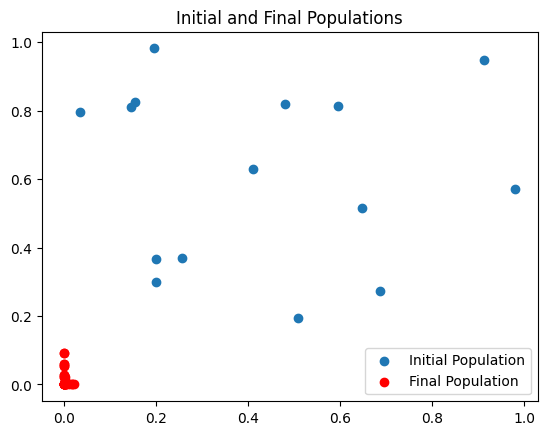

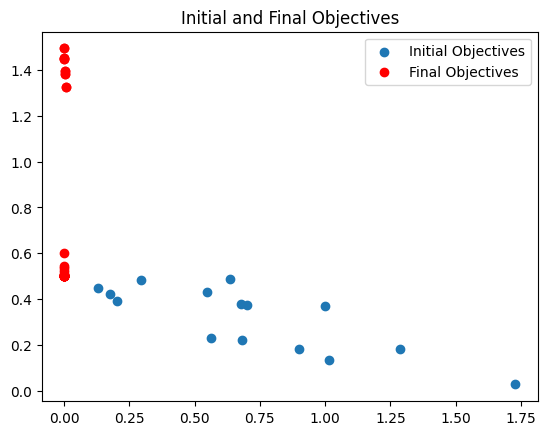

In [241]:
# we define here the main NSGA-II loop
def nsga2(population, generations=10, population_size=35):
    current_population = population.clone()
    for gen in range(generations):
        print(f"Generation {gen+1}")
        # Create offspring population
        offspring = []
        while len(offspring) < population_size:
            parents_indices = torch.randperm(len(current_population))[:2]
            parent1 = current_population[parents_indices[0]]
            parent2 = current_population[parents_indices[1]]
            child1, child2 = crossover(parent1, parent2)
            child1 = mutate(child1)
            child2 = mutate(child2)
            offspring.append(child1)
            offspring.append(child2)
        offspring = torch.stack(offspring)[:population_size]

        # Combine populations
        combined_population = torch.cat((current_population, offspring), dim=0)

        # Fast nondominated sorting
        fronts = fast_nondominated_sort(combined_population)

        # Create new population
        new_population_indices = tournament_selection(combined_population, fronts, k=population_size)
        current_population = combined_population[new_population_indices]

    return current_population
final_population = nsga2(data, generations=25, population_size=35)
print("Final population after NSGA-II:")
print(final_population)

plt.figure()
plt.scatter(data[:, 0].numpy(), data[:, 1].numpy(), label='Initial Population')
plt.scatter(final_population[:, 0].numpy(), final_population[:, 1].numpy(), color='red', label='Final Population')
plt.legend()
plt.title("Initial and Final Populations")
plt.show()

# final objectives plot
# obj 0 = x**2 + y**2  # Objective 1: Minimize distance from origin
# obj 1=  2**(x - 1) + (y - 1)**2- x**y  # Objective 2: Minimize distance from (1,1))
final_objectives = torch.zeros((final_population.shape[0], 2), dtype=torch.float32)
for i in range(final_population.shape[0]):
    x, y = final_population[i]
    final_objectives[i, 0] = x**2 + y**2  # Objective 1: Minimize distance from origin
    final_objectives[i, 1] = 2**(x - 1) + (y - 1)**2- x**y  # Objective 2: Minimize distance from (1,1)
plt.figure()
plt.scatter(objectives[:, 0].numpy(), objectives[:, 1].numpy(), label='Initial Objectives')
plt.scatter(final_objectives[:, 0].numpy(), final_objectives[:, 1].numpy(), color='red', label='Final Objectives')
plt.legend()
plt.title("Initial and Final Objectives")
plt.show()